In [2]:
import numpy as np
import tensorflow as tf
import cvxpy as cp
import scipy.sparse as sp
import matplotlib.pyplot as plt
%matplotlib inline

### Simple LP

Let's start by considering the LP
$$ \begin{split} \min_x \;\; & c^T x \\ \mbox{s.t.} \;\; & A x = b \\ & x \geq 0 \end{split}$$

With Lagrangian (only putting Lagrangian on equality constraint)
$$ \mathcal{L}(x,y) = c^T x + y^T (A x - b) $$
and we'll solve the min-max problem
$$ \min_{x \geq 0} \max_y \mathcal{L}(x,y) $$.


### Exact solution

In [9]:
m,n = (50,100)
#A = sp.random(m,n, density=0.001)
A = np.random.randn(m,n)
b = A.dot(np.random.rand(n))
c = A.T.dot(np.random.randn(m)) + np.random.rand(n)

x = cp.Variable(n)
cons = [A*x == b, x>=0]
cp.Problem(cp.Minimize(c.T*x), cons).solve(verbose=True)
x_star = np.asarray(x.value).T[0]
y_star = np.asarray(cons[0].dual_value).T[0]


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -7.269e+01  -7.269e+01  +3e+02  6e-01  2e-01  1e+00  3e+00    ---    ---    1  1  - |  -  - 
 1  -7.156e+01  -6.939e+01  +1e+02  8e-02  3e-02  2e+00  1e+00  0.8749  3e-01   0  0  0 |  0  0
 2  -7.257e+01  -7.202e+01  +3e+01  1e-02  6e-03  6e-01  4e-01  0.7585  5e-02   1  1  1 |  0  0
 3  -7.247e+01  -7.232e+01  +1e+01  4e-03  2e-03  2e-01  1e-01  0.7392  6e-02   1  1  1 |  0  0
 4  -7.243e+01  -7.240e+01  +3e+00  1e-03  4e-04  3e-02  3e-02  0.8054  1e-01   1  1  1 |  0  0
 5  -7.241e+01  -7.240e+01  +9e-01  4e-04  1e-04  8e-03  1e-02  0.7351  8e-02   1  1  1 |  0  0
 6  -7.241e+01  -7.241e+01  +3e-01  1e-04  4e-05  2e-03  3e-03  0.7513  6e-02   1  1  1 |  0  0
 7  -7.241e+01  -7.241e+01  +8e-02  3e-05  1e-05  2e-04  8e-04  0.9263  2e-01   1  1  1 |  0  0
 8  -7.241e+01  -7.241e+01  +1e-02  4e-06  2e-

# Simple gradient descent

In [18]:
x = np.random.rand(n)
y = np.random.randn(m)

T = 100000
err = np.zeros((T,2))
eta = 0.0001

mx = np.zeros(n)
my = np.zeros(m)
vx = np.zeros(n)
vy = np.zeros(m)

gamma_m = 0.9
gamma_v = 0.99

for i in range(T):
    gx = c + A.T.dot(y)
    gy = A.dot(x) - b
    
    mx = gamma_m*mx + (1-gamma_m)*gx
    my = gamma_m*my + (1-gamma_m)*gy
    vx = gamma_v*vx + (1-gamma_v)*gx**2
    vy = gamma_v*vy + (1-gamma_v)*gy**2

    dx = -(1-gamma_m**i)*mx/(np.sqrt((1-gamma_v**i)*vx)+1e-3)
    dy = (1-gamma_m**i)*my/(np.sqrt((1-gamma_v**i)*vy)+1e-3)
    
    x = np.maximum(0, x + eta*dx)
    y = y + eta*dy

    err[i,:] = np.array([np.linalg.norm(np.minimum(c + A.T.dot(y), 0)), np.linalg.norm(A.dot(x) - b)])


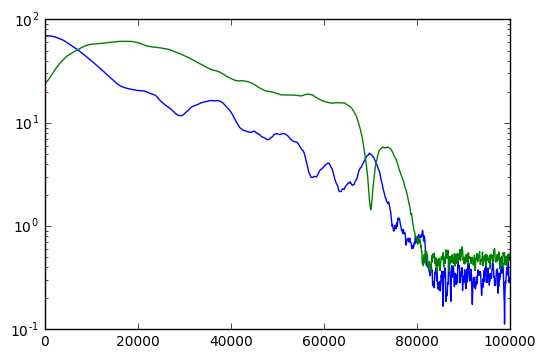

In [19]:
plt.semilogy(err)

### Dual extragradient (seemingly original version)

http://math.haifa.ac.il/yair/accepted-korp-opt-281010.pdf

$$
\begin{split}
\tilde{x}^t & = [x^t - \eta \nabla_x \mathcal{L}(x^t,y^t)]_+ \\
\tilde{y}^t & = y^t + \eta \nabla_y \mathcal{L}(x^t,y^t) \\ 
x^{t+1} & = [x^t - \eta \nabla_x \mathcal{L}(\tilde{x}^t,\tilde{y}^t)]_+ \\
y^{t+1} & = y^t + \eta \nabla_y \mathcal{L}(\tilde{x}^t,\tilde{y}^t) 
\end{split}
$$

In [26]:
#x = np.random.rand(n)
#y = np.random.randn(m)
x = np.zeros(n)
y = np.zeros(m)

T = 10000
err = np.zeros((T,2))
eta = 0.008

rho = 0.02
gamma = 0.0
gamma_ = 0.0

mx = np.zeros(n)
my = np.zeros(m)
vx = np.zeros(n)
vy = np.zeros(m)
gamma_m = 0.5
gamma_v = 0.9


mx_ = np.zeros(n)
my_ = np.zeros(m)
vx_ = np.zeros(n)
vy_ = np.zeros(m)
gamma_m_ = 0.0
gamma_v_ = 0.0

for i in range(T):
    gx = c + A.T.dot(y)#  + 0.1*np.random.randn(n)
    gy = A.dot(x) - b# + 0.1*np.random.randn(m)
    
    mx = gamma_m*mx + (1-gamma_m)*gx
    my = gamma_m*my + (1-gamma_m)*gy
    vx = gamma_v*vx + (1-gamma_v)*gx**2
    vy = gamma_v*vy + (1-gamma_v)*gy**2

    dx = -(1-gamma_m**i)*mx/(np.sqrt((1-gamma_v**i)*vx)+1e-3)
    dy = (1-gamma_m**i)*my/(np.sqrt((1-gamma_v**i)*vy)+1e-3)

    x_ = np.maximum(0, x + eta*dx)
    y_ = y + eta*dy
    
    gx_ = c + A.T.dot(y_)# + 0.1*np.random.randn(n)
    gy_ = A.dot(x_) - b# + 0.1*np.random.randn(m)
    
    
    mx_ = gamma_m_*mx_ + (1-gamma_m_)*gx_
    my_ = gamma_m_*my_ + (1-gamma_m_)*gy_
    vx_ = gamma_v_*vx_ + (1-gamma_v_)*gx_**2
    vy_ = gamma_v_*vy_ + (1-gamma_v_)*gy_**2

    dx = -(1-gamma_m_**i)*mx_#/(np.sqrt((1-gamma_v_**i)*vx_)+1e-3)
    dy = (1-gamma_m_**i)*my_#/(np.sqrt((1-gamma_v_**i)*vy_)+1e-3)
    
    x = np.maximum(0, x + eta*dx)
    y = y + eta*dy

    err[i,:] = np.array([np.linalg.norm(np.minimum(c + A.T.dot(y),0)), np.linalg.norm(A.dot(x) - b)])

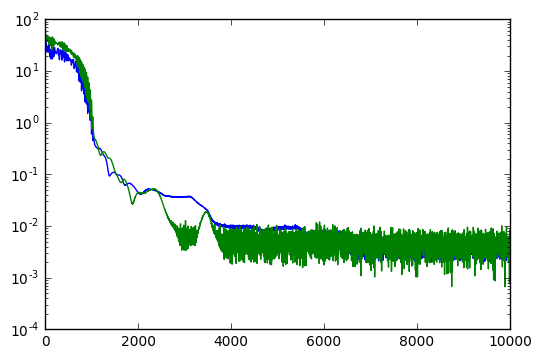

In [27]:
plt.semilogy(err)

In [595]:
x

array([ 0.        ,  0.        ,  1.08792324,  0.        ,  0.58230984,
        0.20308463,  1.53694986,  0.40427403,  0.        ,  0.        ,
        0.        ,  1.18193913,  1.1165986 ,  0.        ,  0.9920764 ,
        0.        ,  1.0466279 ,  0.3311581 ,  0.        ,  0.        ,
        0.        ,  0.59268719,  0.        ,  0.80172713,  0.        ,
        0.22293398,  0.13358909,  0.        ,  0.        ,  0.16090155,
        0.        ,  0.06222745,  0.        ,  1.20291806,  0.        ,
        0.        ,  0.        ,  0.        ,  0.42416993,  0.02162844,
        0.        ,  0.89560598,  0.        ,  0.        ,  0.        ,
        0.79554957,  0.        ,  1.74999323,  1.04776425,  0.4938448 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.62660707,  0.8246596 ,  0.        ,  0.        ,  0.        ,
        0.83988762,  0.        ,  0.        ,  0.        ,  0.67105289,
        0.39295148,  0.86438522,  0.90374707,  1.41327105,  0.  

### Dual extragradient (averaged version)
http://www.jmlr.org/papers/volume7/taskar06a/taskar06a.pdf

$$
\begin{split}
\tilde{x}^t & = [x^t - \eta g_x^t]_+ \\
\tilde{y}^t & = y^t + \eta g_y^t \\ 
x^{t+1} & = [x^t - \eta \nabla_x \mathcal{L}(\tilde{x}^t,\tilde{y}^t)]_+ \\
y^{t+1} & = y^t + \eta \nabla_y \mathcal{L}(\tilde{x}^t,\tilde{y}^t) 
\end{split}$$

Haven't gotten this working yet, and the above seems pretty strong

In [555]:
x0 = np.random.rand(n)
y0 = np.random.randn(m)

sx = np.zeros(n)
sy = np.zeros(m)

T = 100000
err = np.zeros((T,2))
eta = 0.07



gx = np.zeros(n)
gy = np.zeros(m)
x0 = np.zeros(n)
y0 = np.zeros(m)

for i in range(T):
    
    v_x = np.maximum(0, x0.copy())
    v_y = y0.copy()
    
    gx = c + A.T.dot(v_y)
    gy = A.dot(v_x) - b
    u_x = np.maximum(v_x - eta*gx, 0)
    u_y = v_y + eta*gy
    
    gx_ = c + A.T.dot(u_y)
    gy_ = A.dot(u_x) - b
    x0 = np.maximum(0, x0 - eta*gx_)
    y0 += eta*gy_
    
    err[i,:] = np.array([np.linalg.norm(np.minimum(c + A.T.dot(v_y),0)), np.linalg.norm(A.dot(v_x) - b)])

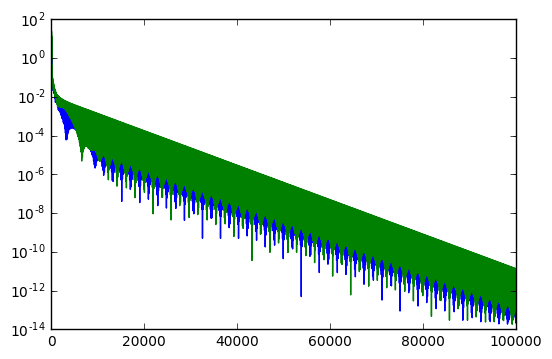

In [556]:
plt.semilogy(err)

### Dual extragradient on augmented Lagrangian

In [40]:
x = np.random.rand(n)
y = np.random.randn(m)

T = 100000
err = np.zeros((T,2))
eta = 0.06

rho = eta
gamma = 0.0
gx = np.zeros(n)
gy = np.zeros(m)

for i in range(T):
    gx = (c + A.T.dot(y))# + rho*A.T.dot(A.dot(x) - b)
    gy = (A.dot(x) - b)# - rho*A.dot(np.minimum(A.T.dot(y) + c,0))
    x_ = np.maximum(0, x - eta*gx)
    y_ = y + eta*gy
    
    gx_ = c + A.T.dot(y_)# + rho*A.T.dot(A.dot(x_) - b)
    gy_ = A.dot(x_) - b# - rho*A.dot(np.minimum(A.T.dot(y_) + c,0))
    x = np.maximum(0, x - eta*gx_)
    y = y + eta*gy_

    err[i,:] = np.array([np.linalg.norm(np.minimum(c + A.T.dot(y),0)), np.linalg.norm(A.dot(x) - b)])

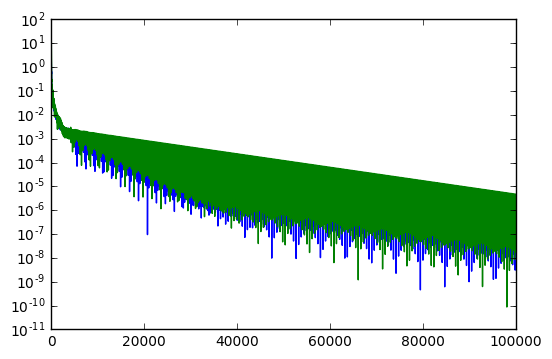

In [41]:
plt.semilogy(err)